**MIMO PROTOYPE**:

Here we try our hand at making MIMO work, and testing its validity with a synthetic toy dataset. The notebook contains the following: 
- Create toy dataset and dataloaders - toy regression data & MNIST?
- Simple MIMO model - regression and classification
- Training and results on toy dataset
- Reliability: confidence vs error - for classification
- Expected calibration errors - for classification
- Diveristity plots - for classification and regression

In [16]:
import numpy as np
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset

***Making the dataset***

We start by making a toy dataset, which will enable us to better understand the network. Since we have full control over the data, we can see how changes impact MIMO.

The most basic problems we can solve with a MIMO-configured neural network is regression. Classification would also be a somewhat simple problem to solve. 

We first generate training data from the function
$$y = x + 0.3 \sin{(2\pi (x+ \epsilon)) + 0.3 \sin{(4\pi (x+\epsilon))}} $$
as described by Blundell et al.

We use $N_{train}=500$ training points and $N_{test}$ testing points. 

In [30]:
# Regression data function
f = lambda x, epsilon: x + 0.3 * np.sin(2*np.pi * (x+epsilon)) + 0.3 * np.sin(4 * np.pi * (x+epsilon)) + epsilon

def generate_data(N, lower, upper, std, f=f):
    # create data
    x = np.linspace(lower, upper, N)

    y = []
    for i in range(N):
        epsilon = np.random.normal(0, std)
        y.append(f(x[i], epsilon))
    return x, y

# Generate train data
N_train = 3000
x, y = generate_data(N_train, lower=-0.25, upper=1, std=0.02)

# Generate validation data
N_val = 200
x_val, y_val = generate_data(N_val, lower=-0.25, upper=1, std=0.02)

# Generate test data
N_test = 200
x_test, y_test = generate_data(N_test, lower=-0.5, upper=1.5, std=0.02)

line = f(x_test, 0)

We make a custom toy dataset class for the MIMO model. During training, the $M$ subnetworks in the model each get a different batch of training samples. We can do this by multiplying the batch size with a factor $M$ such that the effective batch size is:
$$
batch\_size^* = \frac{batch\_size}{M}
$$
This is implemented using a custom collate function.

During inference, the $M$ subnetworks in the model each get the same input. We implement this by multiplying the input $M$ times using another collate function.

In [31]:
class ToyDataset(Dataset):
    """Custom toy dataset"""

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, idx):

        return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)
    
def train_collate_fn(batch, M):
    """Collate function for training MIMO"""
    
    x, y = zip(*batch)
    
    x_chunks = torch.stack(torch.chunk(torch.tensor(x), M, dim=0), dim=1)
    y_chunks = torch.stack(torch.chunk(torch.tensor(y), M, dim=0), dim=1)

    return x_chunks, y_chunks

def test_collate_fn(batch, M):
    """Collate function for testing MIMO"""
    
    x, y = zip(*batch)
    x = torch.tensor(x)[:,None].repeat(1,M)
    y = torch.tensor(y)[:,None].repeat(1,M)

    return x, y

def naive_collate_fn(batch, M):
    """Collate function for naive multiheaded model"""

    x, y = zip(*batch)
    x = torch.tensor(x)[:,None]
    y = torch.tensor(y)[:,None].repeat(1,M)

    return x, y

In [32]:


M = 2
traindata = ToyDataset(x, y)
trainloader = DataLoader(traindata, batch_size=60*M, shuffle=True, collate_fn=lambda x: train_collate_fn(x, M), drop_last=True)
naivetrainloader = DataLoader(traindata, batch_size=60, shuffle=True, collate_fn=lambda x: naive_collate_fn(x, M), drop_last=False)

valdata = ToyDataset(x_val, y_val)
valloader = DataLoader(valdata, batch_size=60, shuffle=False, collate_fn=lambda x: test_collate_fn(x, M), drop_last=False)
naivevalloader = DataLoader(valdata, batch_size=60, shuffle=False, collate_fn=lambda x: naive_collate_fn(x, M), drop_last=False)

testdata = ToyDataset(x_test, y_test)
testloader = DataLoader(testdata, batch_size=N_test, shuffle=False, collate_fn=lambda x: test_collate_fn(x, M), drop_last=False)
naivetestloader = DataLoader(testdata, batch_size=N_test, shuffle=False, collate_fn=lambda x: naive_collate_fn(x, M), drop_last=False)



# Testing
Testing shape of output from train and test loaders

The ``trainloader`` should output a batch where columns are different.

In [33]:
for x_train,y_train in trainloader:
    print(x_train.shape)
    print(y_train.shape)
    break

print(x_train)

torch.Size([60, 2])
torch.Size([60, 2])
tensor([[ 0.2281,  0.1885],
        [ 0.5244,  0.7795],
        [ 0.8812,  0.3819],
        [ 0.1160,  0.2618],
        [ 0.0472,  0.2497],
        [ 0.3873, -0.1029],
        [ 0.2648,  0.3189],
        [ 0.6591,  0.8929],
        [ 0.7978,  0.7232],
        [-0.1691,  0.6816],
        [ 0.1397,  0.0939],
        [ 0.6661,  0.4181],
        [ 0.1660, -0.0908],
        [-0.1679,  0.2981],
        [ 0.9446,  0.5782],
        [ 0.4782,  0.8741],
        [ 0.1689,  0.6732],
        [ 0.9158,  0.2210],
        [ 0.6999, -0.2475],
        [ 0.1376,  0.3494],
        [ 0.4840,  0.0805],
        [ 0.3698,  0.5711],
        [-0.2046,  0.4023],
        [ 0.4327, -0.1358],
        [ 0.7320,  0.3094],
        [ 0.8583,  0.7799],
        [ 0.7670,  0.1526],
        [ 0.8954,  0.2652],
        [ 0.5053,  0.1631],
        [ 0.2293,  0.3585],
        [ 0.2756,  0.9291],
        [ 0.0422, -0.2346],
        [ 0.0734, -0.0858],
        [ 0.1597,  0.1385],
        

The MIMO dataloaders should output a batch with size $(batch\_size, M)$

In [34]:
for test_x, test_y in testloader:
    print(test_x.shape)
    print(test_y.shape)
    break


torch.Size([200, 2])
torch.Size([200, 2])


The dataloader for the naive multiheaded model should output a batch with size $(batch\_size, 1)$ for the features $x$ and labels (batch_size, M) for $y$.

In [35]:
for naive_x_train, naive_y_train in naivetrainloader:
    print(naive_x_train.shape)
    print(naive_y_train.shape)
    break


torch.Size([60, 1])
torch.Size([60, 2])


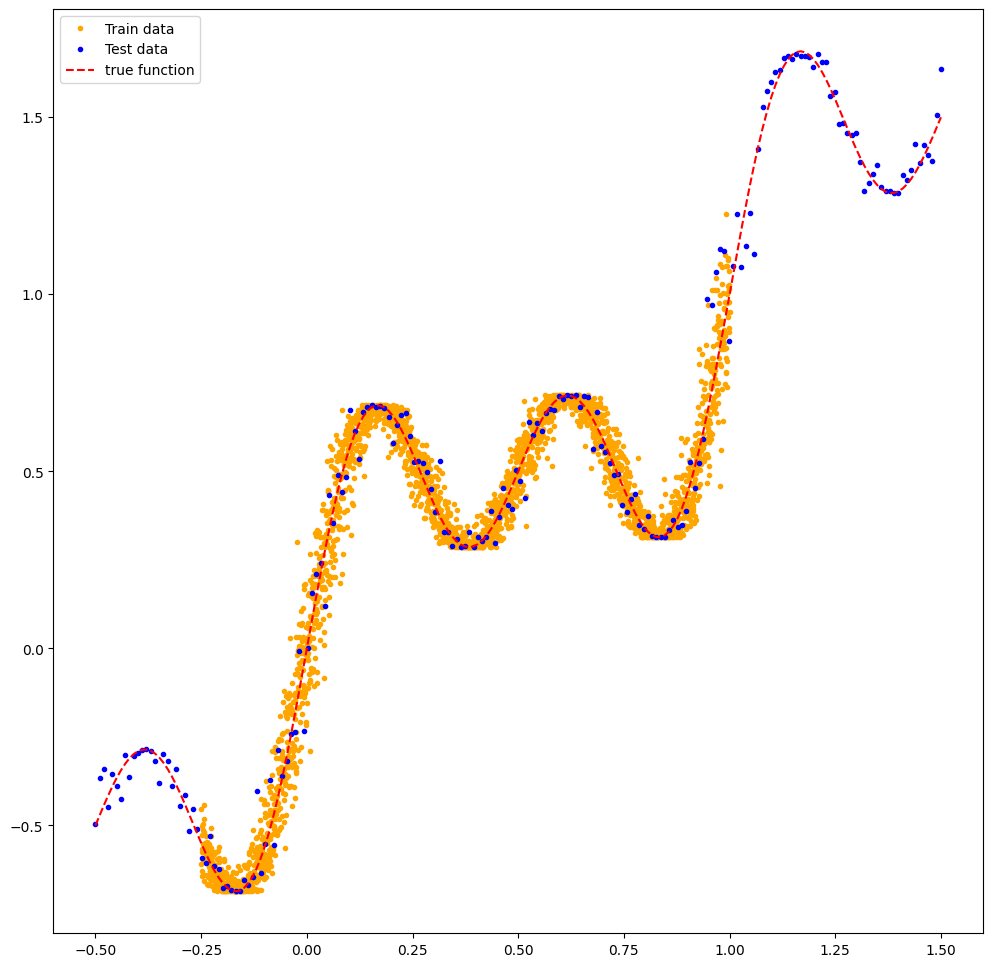

In [36]:
# plot data
fig, ax = plt.subplots(1,1, figsize=(12,12))

ax.plot(x, y, '.', label='Train data', color='orange')
ax.plot(x_test, y_test, '.', label='Test data', color='blue')
ax.plot(x_test, line, '--', label='true function', color='red')
ax.legend()
plt.show()

***Building the model***

The model is a MIMO configured neural network. To keep it simple for now we choose to have $M=2$, so we use 2 subnetworks.
The neural network will consist of two feed-forward aka linear layers with 32 and 128 hidden units in each. For activation function we will use ReLU as it is the norm within the field.

We choose the number of hidden units we did, so that our architecture would be the same as the one given in the MIMO paper when they fit a MIMO model to this synthetic data.

We make sure that we can get both the averaged output (ensemble output) and individual ensemble member output. This will help us illustrate the diversity of the ensemble members.

In [37]:
# Define the model
hidden_units = 32
hidden_units2 = 128

class MIMONetwork(nn.Module):
    def __init__(self, n_subnetworks):
        super().__init__()
        self.n_subnetworks = n_subnetworks
        self.model = torch.nn.Sequential(
            nn.Linear(self.n_subnetworks, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units,hidden_units2),
            nn.ReLU(),
            nn.Linear(hidden_units2, self.n_subnetworks)
        )

    def forward(self, x):
        individual_outputs = self.model(x)
        output = torch.mean(individual_outputs, dim=1)
        return output, individual_outputs

MIMO_model = MIMONetwork(n_subnetworks=M)

class NaiveNetwork(nn.Module):
    def __init__(self, n_subnetworks):
        super().__init__()
        self.n_subnetworks = n_subnetworks
        self.model = torch.nn.Sequential(
            nn.Linear(1, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units,hidden_units2),
            nn.ReLU(),
            nn.Linear(hidden_units2, self.n_subnetworks)
        )

    def forward(self, x):
        individual_outputs = self.model(x)
        output = torch.mean(individual_outputs, dim=1)
        return output, individual_outputs

naive_model = NaiveNetwork(n_subnetworks=M)

In [44]:
# useful functions 🤖

def train(model, optimizer, trainloader, valloader, epochs=500, model_name='MIMO', val_every_n_epochs=10):

    losses = []
    val_losses = []

    best_val_loss = np.inf

    for e in range(epochs):
        
        for x_, y_ in trainloader:

            model.train()

            x_,y_ = x_.float(), y_.float()

            optimizer.zero_grad()

            output, individual_outputs = model(x_)
            loss = nn.functional.mse_loss(individual_outputs, y_)

            loss.backward()
            optimizer.step()

            losses.append(loss.item())  

        if (e+1) % val_every_n_epochs == 0:
            model.eval()

            val_loss_list = []
            with torch.no_grad():
                for val_x, val_y in valloader:
                    val_x, val_y = val_x.float(), val_y.float()
                    val_output, val_individual_outputs = model(val_x)
                    val_loss = nn.functional.mse_loss(val_individual_outputs, val_y)
                    val_loss_list.append(val_loss.item())

            val_losses.extend(val_loss_list)
            mean_val_loss = np.mean(val_loss_list)
            if mean_val_loss < best_val_loss:
                best_val_loss = mean_val_loss
                torch.save(model, f'{model_name}.pt')
            # print(f"Mean validation loss at epoch {e}: {mean_val_loss}")

    return losses, val_losses

def get_train_val_dataloaders(N_train=500, N_val=200, is_naive=False):
    # Generate train data
    x, y = generate_data(N_train, lower=-0.25, upper=1, std=0.02)

    # Generate validation data
    x_val, y_val = generate_data(N_val, lower=-0.25, upper=1, std=0.02)

    # make dataset and get dataloaders
    traindata = ToyDataset(x, y)
    valdata = ToyDataset(x_val, y_val)
    
    if is_naive:
        trainloader = DataLoader(traindata, batch_size=60, shuffle=True, collate_fn=lambda x: naive_collate_fn(x, M), drop_last=False)
        valloader = DataLoader(valdata, batch_size=60, shuffle=False, collate_fn=lambda x: naive_collate_fn(x, M), drop_last=False)
    else:
        trainloader = DataLoader(traindata, batch_size=60*M, shuffle=True, collate_fn=lambda x: train_collate_fn(x, M), drop_last=True)
        valloader = DataLoader(valdata, batch_size=60, shuffle=False, collate_fn=lambda x: test_collate_fn(x, M), drop_last=False)  
    
    return trainloader, valloader



def train_K_repitions(M, epochs=500, val_every_n_epochs=10, repititions=20, is_naive=False):

    K_losses = {}
    K_val_losses = {}

    for k in tqdm(range(repititions)):

        model = NaiveNetwork(n_subnetworks=M) if is_naive else MIMONetwork(n_subnetworks=M)
        name = 'naive_models/Naive' if is_naive else 'mimo_models/MIMO'

        optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
        
        trainloader, valloader = get_train_val_dataloaders(N_train, N_val, is_naive=is_naive)

        losses, val_losses = train(model, optimizer, trainloader, valloader, epochs=epochs, model_name=f'{name}_{k}', val_every_n_epochs=val_every_n_epochs)

        K_losses[k] = losses
        K_val_losses[k] = val_losses

    return K_losses, K_val_losses


def plot_loss(losses, val_losses):

    fig, ax = plt.subplots(1,2, figsize=(12,6))

    ax[0].plot(losses, label='Train loss')
    ax[0].set_title('Train loss')
    ax[0].set_xlabel('Iterations')
    ax[0].set_ylabel('Loss')

    ax[1].plot(val_losses, label='Validation loss', color='orange')
    ax[1].set_title('Validation loss')
    ax[1].set_xlabel('Iterations')
    ax[1].set_ylabel('Loss')

    plt.show()

We train one MIMO model and one Naive model with $M=2$ subnetworks. 

In [45]:
# train one MIMO model
M = 2
MIMO_model = MIMONetwork(n_subnetworks=M)
optimizer = torch.optim.Adam(MIMO_model.parameters(), lr=3e-4)

losses, val_losses = train(MIMO_model, optimizer, epochs=5000, trainloader=trainloader, valloader=valloader, val_every_n_epochs=10, model_name='MIMO')
# plot loss 
plot_loss(losses, val_losses)

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [ ]:
# train one Naive model
M = 2
naive_model = NaiveNetwork(n_subnetworks=M)
optimizer = torch.optim.Adam(naive_model.parameters(), lr=3e-4)

losses, val_losses = train(naive_model, optimizer, epochs=5000, trainloader=naivetrainloader, valloader=naivevalloader, val_every_n_epochs=10, model_name='Naive')
# plot loss 
plot_loss(losses, val_losses)


We can also try to train MIMO and Naive models with $M=2$ subnetworks using $K=10$ repititions to see how the variance generalises across repititions, as described by Havasi et al. in their explainer notebook. 
This means that we train $K=10$ versions of the MIMO models (on different sampled data) and then evaluate what they describe as the expected mean squared error 
$$
\mathcal{E}_M = \mathbb{E}_{\bm{x}',y' \in \mathbb{X}_{\text{test}}} [\mathbb{E}_{\mathbb{X}}[(\hat{f}_M(\bm{x}',...,\bm{x}')- y')^2]]
$$
Through bias-variance decomposition, we can get the variance as:
$$
\mathbb{E}_{\bm{x}',y' \in \mathbb{X}_{\text{test}}} [\mathbb{E}_{\mathbb{X}}[(\bar{f}_M(\bm{x}',...,\bm{x}')- \hat{f}_M(\bm{x}',...,\bm{x}'))^2]]
$$
where $\hat{f}_M$ is a regressor with $M$ subnetworks and $\bar{f}_M = \frac{1}{K} \sum_{k=1}^K \hat{f}(x)$ 

In [142]:
# train MIMO model
M = 2
# number of repititions
K = 10
is_naive = False

K_losses, K_val_losses = train_K_repitions(M, epochs=5000, val_every_n_epochs=2, repititions=K, is_naive=is_naive)

  0%|          | 0/10 [00:00<?, ?it/s]

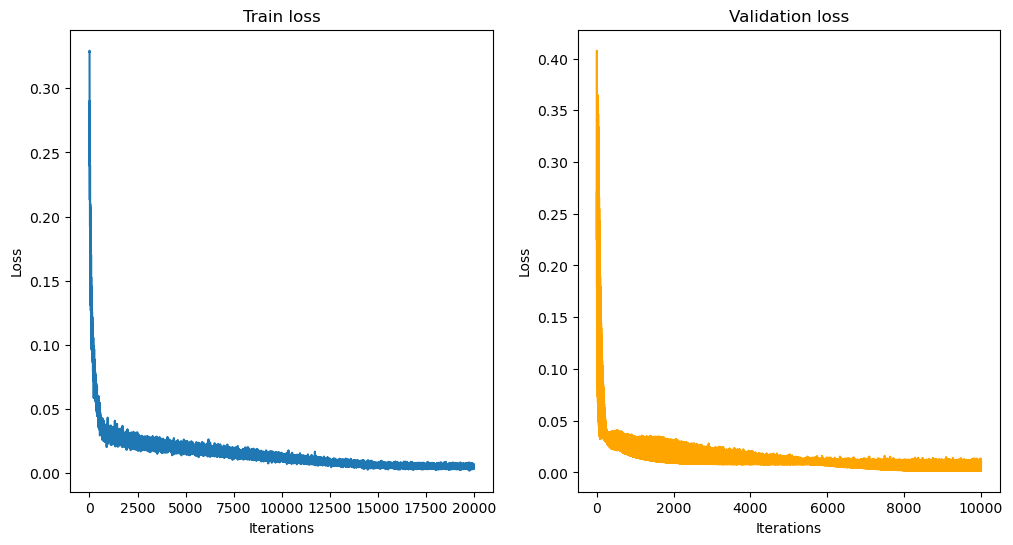

In [143]:
# plot loss for one of the repititions
plot_loss(K_losses[0], K_val_losses[0])

In [144]:
# train Naive model
M = 2
# number of repititions
K = 10
is_naive = True

K_losses, K_val_losses = train_K_repitions(M, epochs=500, val_every_n_epochs=2, repititions=K, is_naive=is_naive)


  0%|          | 0/10 [00:00<?, ?it/s]

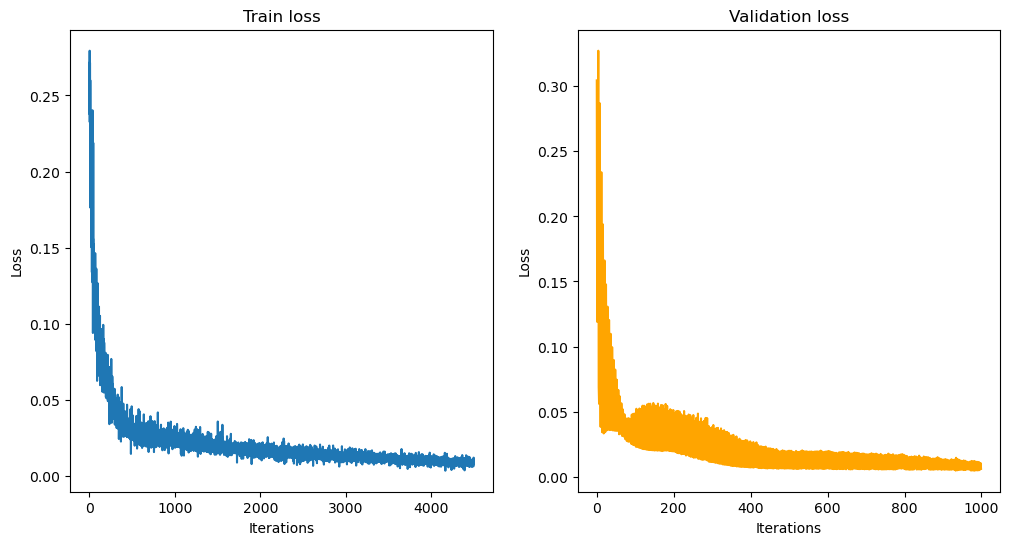

In [145]:
# plot loss for one of the repititions
plot_loss(K_losses[0], K_val_losses[0])

# Inference
We test the model on the test set and try to predict the function. We predict the mean outputs (of ensemble member) and of individual members.

In [26]:
# def inference(model, testloader):
#     predictions = []
#     pred_individual = []
#     test_ys = []

#     for test_x, test_y in testloader:
#         output, individual_outputs = model(test_x.float())
        
#         predictions.extend(list(output.detach().numpy()))
#         test_ys.extend(list(test_y.detach().numpy()[:,0]))
#         pred_individual.extend(list(individual_outputs.detach().numpy()))

#     return np.array(predictions), np.array(pred_individual), np.array(test_ys)

In [27]:
K = 10
naive_dir = "naive_models"
mimo_dir = "mimo_models"

naive_models = [os.path.join(naive_dir, f) for f in os.listdir(naive_dir)]
mimo_models = [os.path.join(mimo_dir, f) for f in os.listdir(mimo_dir)]

def indef rep_inference(models, testloader)f_hats = np.zeros((K, N_test))

    for i, mod in enumerate(models):

        for test_x, test_y in testloader:

            model = torch.load(mod)
            model.eval()

            output, individual_outputs = model(test_x.float())
            
            f_hats[i,:N_test] = output.detach().numpy()

    return f_hats

def get_predictions(f_hats):
    f_bar = np.mean(f_hats, axis=0)
    variances = np.mean(np.array([(f_bar - f_hat)**2 for f_hat in f_hats]), axis=0)

    return f_bar, variances

naive_f_hats = inference(naive_models, naivrep_etestloader)
mimo_f_hats = inference(mimo_models, testlorep_ader)

naive_predicitons, naive_variances = get_predictions(naive_f_hats)
mimo_predictions, mimo_variances = get_predictions(mimo_f_hats)


**Analysis**

We need to analyse the trained network to see if the MIMO network works as desired. We try to replicate some of the plots in the MIMO paper to make sure that it works properly.

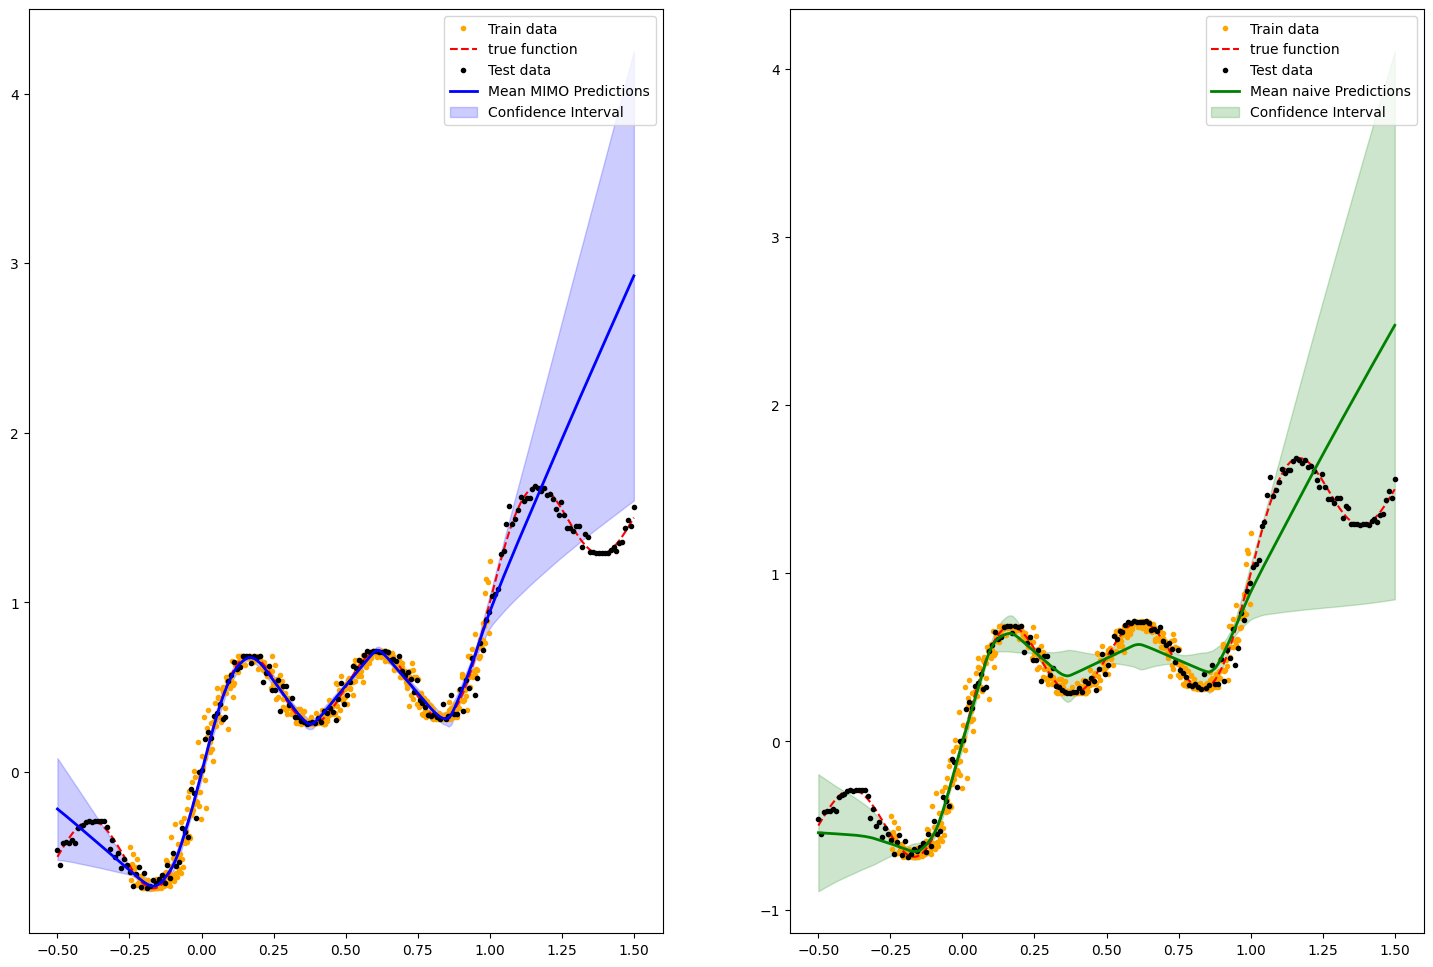

In [28]:
# plot data
fig, ax = plt.subplots(1,2, figsize=(18,12))

### plot mimo ###
ax[0].plot(x, y, '.', label='Train data', color='orange')
ax[0].plot(x_test, line, '--', label='true function', color='red')
# plot test data
ax[0].plot(x_test, y_test, '.', label='Test data', color='black')

# plot predicitons with confidence intervals
ax[0].plot(x_test, mimo_predictions, '-', label='Mean MIMO Predictions', color='blue', linewidth=2)
ax[0].fill_between(x_test, mimo_predictions - 1.96*np.sqrt(mimo_variances), mimo_predictions + 1.96*np.sqrt(mimo_variances), color='blue', alpha=0.2, label='Confidence Interval')
ax[0].legend()

### naive ###
ax[1].plot(x, y, '.', label='Train data', color='orange')
ax[1].plot(x_test, line, '--', label='true function', color='red')
# plot test data
ax[1].plot(x_test, y_test, '.', label='Test data', color='black')

# plot predicitons with confidence intervals
ax[1].plot(x_test, naive_predicitons, '-', label='Mean naive Predictions', color='green', linewidth=2)
ax[1].fill_between(x_test, naive_predicitons - 1.96*np.sqrt(naive_variances), naive_predicitons + 1.96*np.sqrt(naive_variances), color='green', alpha=0.2, label='Confidence Interval')
ax[1].legend()

plt.show()
